# model

In [403]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import roc_auc_score

In [404]:
# knob 종류 및 바운드
[305, 722, 5, 12, 9163, 'no', 'yes']
knobs_rdb = {
    
    "hash-max-ziplist-entries":     (256, 751), 
    "hash-max-ziplist-value": (16, 257),
    "activerehashing": ('yes', 'no'),  ##yes
    "hz": (1, 41),
    "dynamic-hz": ('yes', 'no'),

    "save0_0": (700,1100),
    "save0_1": (1,9),
    "save1_0": (100,500),
    "save1_1": (10,100),
    "save2_0": (30,90),
    "save2_1": (8000,12000),

    "rdbcompression": ('yes', 'no'), ##yes
    "rdbchecksum": ('yes', 'no'),    ##yes
    "rdb-save-incremental-fsync": ('yes', 'no'),   ## yes

#     "activedefrag": ('yes','no'),  
    "active-defrag-threshold-lower": (1, 31),
    "active-defrag-threshold-upper": (70, 101),
    "active-defrag-cycle-min": (1, 31),
    "active-defrag-cycle-max": (70, 91),
    
    "maxmemory": (1000, 2900),   ##"volatile-lru"
    "maxmemory-policy":     ("volatile-lru", "allkeys-lru", "volatile-lfu", "allkeys-lfu", 
                             "volatile-random","allkeys-random", "volatile-ttl", "noeviction"),
    "maxmemory-samples": (3, 7),
    
    "lazyfree-lazy-eviction": ('yes', 'no'),
    "lazyfree-lazy-expire": ('yes', 'no'),
    "lazyfree-lazy-server-del": ('yes', 'no')
}

knobs_list = list(knobs_rdb.keys())
knobs_bound = list(knobs_rdb.values())

## 데이터 전처리
* 이상치 파악
* test, train 데이터 잘 나뉘어졌는지 확인

In [405]:
# config(knob) data
# config_df = pd.read_csv("./data/result_config0.csv", sep=',')
config_df = pd.read_csv("./data/result_config5.csv", sep=',')

# external(throughput) data
# external_df = pd.read_csv("./data/external_metrics0.csv", sep=',')
external_df = pd.read_csv("./data/external_metrics5.csv", sep=',')

In [406]:
# config(knog), external(throughput) 데이터 하나의 프레임으로 결합
dataset = config_df
dataset['throughput'] = external_df['Gets_KB/sec']

In [407]:
dataset.head(3)

,appendonly,appendfsync,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,no-appendfsync-on-rewrite,aof-rewrite-incremental-fsync,aof-use-rdb-preamble,save0_0,save0_1,save1_0,...,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,throughput
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,868,4,320,...,5,yes,yes,yes,506,144,no,20,yes,45305.88
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,867,6,258,...,4,yes,no,yes,552,141,no,22,yes,44540.19
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,911,6,319,...,5,yes,no,yes,552,185,yes,20,no,45261.71


In [408]:
# 결측치 처리 
dataset_nan = dataset.copy()
dataset = dataset.fillna(value = 0)  # 전부 0으로 채움

---

### activedefrag 확인

In [411]:
act_compare_list = ['activedefrag', 'throughput']
dataset_nan = dataset_nan[act_compare_list]
act_index = dataset_nan.dropna().index()


,activedefrag,throughput
3,yes,45108.96
4,yes,45277.43
5,yes,45304.80
9,yes,44982.43
10,yes,45162.27
...,...,...
1691,yes,45092.26
1693,yes,44645.52
1695,yes,44861.25
1696,yes,45034.29


In [416]:
# nan 가 아닌거
dataset_nan_act = dataset_nan[dataset_nan['activedefrag'].notna()]

# nan인거
dataset_nan_act_nan = dataset_nan[dataset_nan['activedefrag'].isna()]

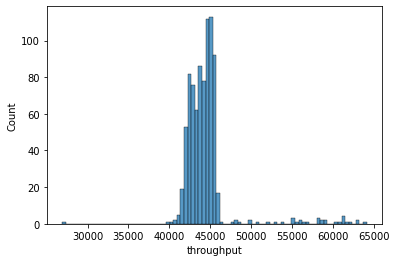

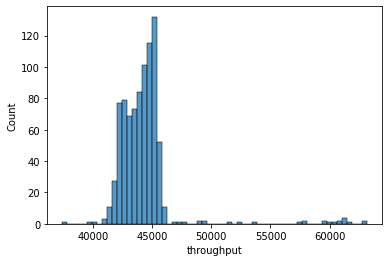

In [420]:
import seaborn as sns
sns.histplot(dataset_nan_act['throughput'])
plt.show()

import seaborn as sns
sns.histplot(dataset_nan_act_nan['throughput'])
plt.show()

/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


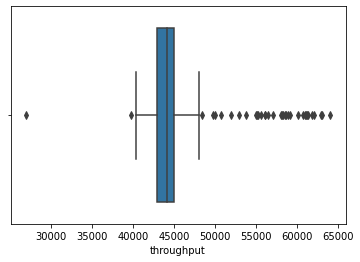

/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


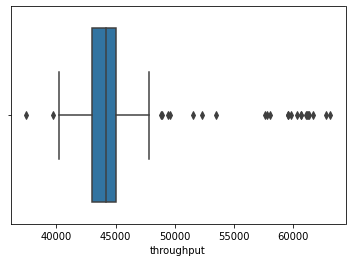

In [427]:
import seaborn as sns
sns.boxplot(dataset_nan_act['throughput'])
plt.show()

import seaborn as sns
sns.boxplot(dataset_nan_act_nan['throughput'])
plt.show()

In [425]:
print(dataset_nan_act.describe())
print(dataset_nan_act_nan.describe())

         throughput
count    837.000000
mean   44450.625293
std     3062.921291
min    26918.970000
25%    42952.760000
50%    44171.360000
75%    45034.290000
max    64115.000000
         throughput
count    863.000000
mean   44321.185342
std     2597.419050
min    37426.380000
25%    43016.310000
50%    44205.720000
75%    45026.530000
max    63134.480000


---

In [396]:
# maxmemory knob 단위(mb) 처리
dataset['maxmemory']  = dataset['maxmemory'].str.strip('mb')
dataset['maxmemory'] = pd.to_numeric(dataset['maxmemory'])

In [397]:
# Object 변수 categorical 로 변경 (LightGBM에 바로 넣기 위해)
category_knob = []

for knob in dataset:
    if dataset[knob].dtype == 'O':  # Object인 경우 category 형으로 변경
        dataset[knob] = dataset[knob].astype('category')
        if knob in knobs_list:
            category_knob.append(knob)

In [398]:
# 설정한 knob들만 추출
extract_knobs_list = knobs_list.copy()
extract_knobs_list.append('throughput')  # target 값 추가

dataset = dataset[extract_knobs_list]

In [399]:
dataset.head(3)

,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,save0_0,save0_1,save1_0,save1_1,save2_0,...,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,maxmemory-policy,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,throughput
0,506,144,no,20,yes,868,4,320,58,58,...,0.0,0.0,0.0,1500,volatile-random,5,yes,yes,yes,45305.88
1,552,141,no,22,yes,867,6,258,52,67,...,0.0,0.0,0.0,1500,allkeys-lfu,4,yes,no,yes,44540.19
2,552,185,yes,20,no,911,6,319,54,65,...,0.0,0.0,0.0,2900,noeviction,5,yes,no,yes,45261.71


In [358]:
# 결측치 처리전 확인
print(dataset_nan.info())

# 결측치 처리후 확인
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   appendonly                     0 non-null      float64
 1   appendfsync                    0 non-null      float64
 2   auto-aof-rewrite-percentage    0 non-null      float64
 3   auto-aof-rewrite-min-size      0 non-null      float64
 4   no-appendfsync-on-rewrite      0 non-null      float64
 5   aof-rewrite-incremental-fsync  0 non-null      float64
 6   aof-use-rdb-preamble           0 non-null      float64
 7   save0_0                        1700 non-null   int64  
 8   save0_1                        1700 non-null   int64  
 9   save1_0                        1700 non-null   int64  
 10  save1_1                        1700 non-null   int64  
 11  save2_0                        1700 non-null   int64  
 12  save2_1                        1700 non-null   i

### 이상치 처리

In [359]:
# -999999와 같은 이상치 확인 -> 없음
dataset.describe()

,hash-max-ziplist-entries,hash-max-ziplist-value,hz,save0_0,save0_1,save1_0,save1_1,save2_0,save2_1,active-defrag-threshold-lower,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,maxmemory-samples,throughput
count,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000
mean,503.073529,136.014118,20.331765,899.707647,5.018824,301.504118,54.734706,60.100588,10003.781176,7.648235,41.854118,7.588824,39.392353,1938.529412,4.999412,44384.915482
std,40.678152,20.991291,3.175918,33.353880,0.747528,33.671656,7.505045,5.084096,337.575574,7.950170,42.548603,7.905846,40.028266,571.372337,0.362289,2836.074574
min,365.000000,68.000000,9.000000,792.000000,2.000000,200.000000,30.000000,44.000000,8680.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,4.000000,26918.970000
25%,476.000000,122.000000,18.000000,877.000000,5.000000,278.000000,50.000000,57.000000,9781.500000,0.000000,0.000000,0.000000,0.000000,1500.000000,5.000000,42970.870000
50%,503.000000,135.000000,20.000000,899.000000,5.000000,302.000000,55.000000,60.000000,9999.500000,0.000000,0.000000,0.000000,0.000000,1900.000000,5.000000,44181.360000
75%,531.000000,150.000000,22.000000,922.000000,5.000000,325.000000,60.000000,63.000000,10229.000000,15.000000,85.000000,15.000000,80.000000,2400.000000,5.000000,45033.152500
max,635.000000,204.000000,33.000000,1016.000000,7.000000,413.000000,78.000000,75.000000,11169.000000,23.000000,93.000000,23.000000,85.000000,2900.000000,6.000000,64115.000000


<AxesSubplot:>

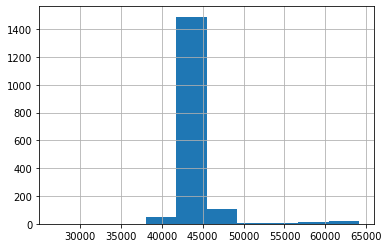

In [360]:
# 이상치 파악 
dataset['throughput'].hist()

In [361]:
# 인덱스제거하고 돌려보자
print(dataset['throughput'][dataset['throughput'] <= 52500])
outlier_index = dataset['throughput'][dataset['throughput'] <= 52500].index
print('개수: ', len(outlier_index))

0       45305.88
1       44540.19
2       45261.71
3       45108.96
4       45277.43
          ...   
1695    44861.25
1696    45034.29
1697    45003.06
1698    44653.27
1699    44799.15
Name: throughput, Length: 1655, dtype: float64
개수:  1655


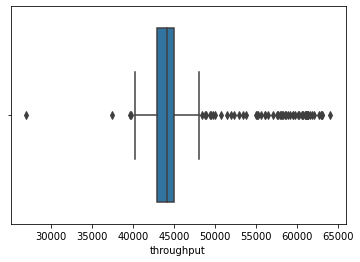

In [362]:
# 이상치 제거 전 상자그림
# 이상치로 분류되진 않지만 제거한다. 
import seaborn as sns
sns.boxplot(x = "throughput",data = dataset )
plt.show()

In [363]:
# # 이상치 제거
# dataset = dataset.drop(outlier_index)

In [364]:
# 이상치 제거 확인
dataset.shape

(1700, 25)

In [365]:
# 타입 확인 (카테고리)
dataset.dtypes

hash-max-ziplist-entries            int64
hash-max-ziplist-value              int64
activerehashing                  category
hz                                  int64
dynamic-hz                       category
save0_0                             int64
save0_1                             int64
save1_0                             int64
save1_1                             int64
save2_0                             int64
save2_1                             int64
rdbcompression                   category
rdbchecksum                      category
rdb-save-incremental-fsync       category
active-defrag-threshold-lower     float64
active-defrag-threshold-upper     float64
active-defrag-cycle-min           float64
active-defrag-cycle-max           float64
maxmemory                           int64
maxmemory-policy                 category
maxmemory-samples                   int64
lazyfree-lazy-eviction           category
lazyfree-lazy-expire             category
lazyfree-lazy-server-del         c

### test, train 데이터 분리

In [366]:
# train 8, test 2
X_train_val, X_test, y_train_val, y_test = train_test_split(dataset.iloc[:,:-1]
                                                    , dataset['throughput'] 
                                                    ,test_size=0.2
                                                   , random_state = 156)

# train 6 test 2
X_train, X_val, y_train, y_val = train_test_split(X_train_val
                                                    , y_train_val 
                                                    ,test_size=0.25
                                                   , random_state = 156)


In [367]:
# X_train 확인
X_train.head()

,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,save0_0,save0_1,save1_0,save1_1,save2_0,...,active-defrag-threshold-lower,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,maxmemory-policy,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del
1645,496,127,no,19,yes,884,6,349,75,64,...,0.0,0.0,0.0,0.0,1800,volatile-random,5,yes,no,no
522,490,148,no,20,no,848,4,346,63,57,...,15.0,85.0,13.0,82.0,2900,volatile-ttl,4,yes,yes,no
445,568,147,yes,20,yes,894,6,254,59,62,...,11.0,86.0,14.0,80.0,1300,allkeys-lru,5,no,yes,no
220,580,128,yes,23,no,906,4,326,48,67,...,0.0,0.0,0.0,0.0,1900,volatile-lru,5,yes,yes,no
1611,480,136,no,18,yes,883,4,243,71,60,...,0.0,0.0,0.0,0.0,1500,volatile-ttl,5,no,no,yes


In [368]:
# # test, train 에 비슷하게 분류됬는지 확인
# y_train.hist()
# plt.title('train data')
# plt.show()

# y_test.hist()
# plt.title('test data')
# plt.show()

## LightGBM 모델 생성

In [370]:
# 모델 객체 생성, n_estimators = 400으로 설정
lgbm_wrapper = LGBMRegressor(n_estimators=1000, learning_rate=0.1)

# 검증 데이터(validation data)
evals = [(X_val, y_val)]

lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc',
                eval_set = evals, verbose = True, categorical_feature=category_knob)


[1]	valid_0's auc: 1	valid_0's l2: 7.24503e+06
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 1	valid_0's l2: 7.21582e+06
[3]	valid_0's auc: 1	valid_0's l2: 7.19e+06
[4]	valid_0's auc: 1	valid_0's l2: 7.16154e+06
[5]	valid_0's auc: 1	valid_0's l2: 7.16496e+06
[6]	valid_0's auc: 1	valid_0's l2: 7.18558e+06
[7]	valid_0's auc: 1	valid_0's l2: 7.21274e+06
[8]	valid_0's auc: 1	valid_0's l2: 7.20442e+06
[9]	valid_0's auc: 1	valid_0's l2: 7.23668e+06
[10]	valid_0's auc: 1	valid_0's l2: 7.27831e+06
[11]	valid_0's auc: 1	valid_0's l2: 7.29073e+06
[12]	valid_0's auc: 1	valid_0's l2: 7.28766e+06
[13]	valid_0's auc: 1	valid_0's l2: 7.33869e+06
[14]	valid_0's auc: 1	valid_0's l2: 7.35963e+06
[15]	valid_0's auc: 1	valid_0's l2: 7.40025e+06
[16]	valid_0's auc: 1	valid_0's l2: 7.38563e+06
[17]	valid_0's auc: 1	valid_0's l2: 7.44351e+06
[18]	valid_0's auc: 1	valid_0's l2: 7.43369e+06
[19]	valid_0's auc: 1	valid_0's l2: 7.46954e+06
[20]	valid_0's auc: 1	valid_0's l2: 7.

LGBMRegressor(n_estimators=1000)

## 성능 평가

In [371]:
# 성능 측정 함수 RMSLE(캐글에서 요구한 성능 평가 방법), MSE, RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산 
def rmsle(y, pred):
    # log1p 변환
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    
    # squred 계산
    squared_error = (log_y-log_pred)**2
    
    # RMSE 계산
    rmsle = np.sqrt(np.mean(squared_error))
    
    return rmsle

# 사이킷런의 mean_square_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))
    

In [372]:
preds = lgbm_wrapper.predict(X_test)  # 예측 결과
evaluate_regr(y_test, preds)

RMSLE: 0.052, RMSE: 2528.660, MAE: 1359.666


이상치 제거 전 RMSLE: 0.060, RMSE: 3492.223, MAE: 3032.843

이상치 제거 후 RMSLE: 0.058, RMSE: 3393.720, MAE: 2974.377

In [373]:
X_test.iloc[:1,:]

,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,save0_0,save0_1,save1_0,save1_1,save2_0,...,active-defrag-threshold-lower,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,maxmemory-policy,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del
1050,500,142,no,33,no,933,5,282,61,61,...,0.0,0.0,0.0,0.0,1200,allkeys-lfu,5,yes,yes,yes


In [374]:
# lgbm_wrapper.predict(X_test.iloc[3:4,:])

In [375]:
# 예측 prediction 시험

df_result_test = {}

for i in knobs_list:
    df_result_test[i] = ''

df_result_test['save0_0'] = [929]
df_result_test['save0_1'] = [6]
df_result_test['save1_1'] = [48]
df_result_test['save2_1'] = [10504]
df_result_test['hash-max-ziplist-entries'] = [372]  #(256, 751)
df_result_test['rdb-save-incremental-fsync'] = ['no']
df_result_test['lazyfree-lazy-expire'] = ['yes']

df_result_test['save2_0'] = [74]
df_result_test['rdbcompression'] = ['yes']
df_result_test['active-defrag-cycle-max'] = [91]
df_result_test['maxmemory'] = [1223]
df_result_test['maxmemory-samples'] = [5]



df_result_test2 = pd.DataFrame(df_result_test)
# for idx, ty in enumerate(list(df_result_test2.dtypes)):
#     if ty == 'O':
#         df_result_test2.iloc[0,idx].astype('category')
    
for elem in df_result_test2:
    if df_result_test2[elem].dtype == 'O':
        
        df_result_test2[elem] = df_result_test2[elem].astype('category')
        
lgbm_wrapper.predict(df_result_test2.iloc[:1,:])[0]

ValueError: train and valid dataset categorical_feature do not match.

In [150]:
# df_result_test2

In [151]:
lgbm_wrapper.predict(df_result_test2)

ValueError: train and valid dataset categorical_feature do not match.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

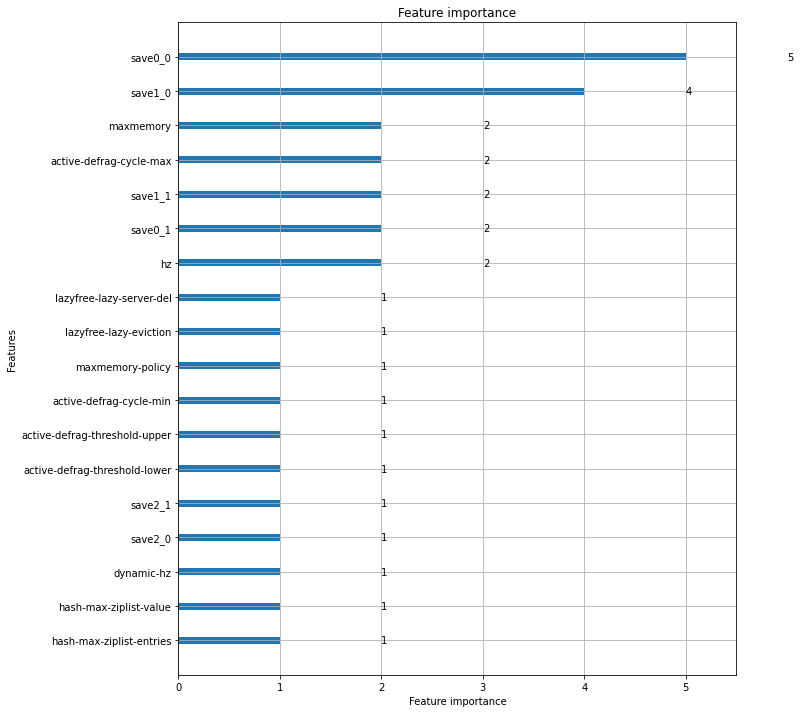

In [376]:
# plot_importance()를 이영해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax= ax)

In [377]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mse = mean_squared_error(y_test ,preds)
mse

6394119.15635138

### 하이퍼파라미터 튜닝

In [233]:
# from sklearn.model_selection import GridSearchCV

# # 하이퍼파라미터 튜닝시 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
# lgbm_wrapper = LGBMRegressor(n_estimators = 200)

# params = {
#     'num_leaves':[32, 64],
#     'max_depth':[128, 160],
#     'min_child_samples':[60, 100],
#     'subsample':[0.8, 1]
# }

# # cv는 3으로 가정 (교차 검증을 자동으로 해주는건가?)
# gridcv = GridSearchCV(lgbm_wrapper, param_grid = params, cv=3)
# gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric='auc', 
#           eval_set = [(X_train, y_train), (X_test, y_test)])

# print('GridSeaerchCV 최적 파라미터:', gridcv.best_params_)

In [234]:
# # 하이퍼 파라미터 적용 후 다시 생성
# lgbm_wrapper = LGBMRegressor(n_estimators = 1000,
#                             num_leaves = 32,
#                             subsample=0.8,
#                             min_child_samples=60,
#                             max_depth=128)

# evals = [(X_test, y_test)]

# lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100,
#                 eval_metric='auc',
#                 eval_set=evals,
#                 verbose=True)

---

# BO

In [235]:
# knob 종류 및 바운드

knobs_rdb2 = {
    
#     "hash-max-ziplist-entries":     (256, 751), 
#     "hash-max-ziplist-value": (16, 257),
#     "activerehashing": ('yes', 'no'),  ##yes
#     "hz": (1, 41),
#     "dynamic-hz": ('yes', 'no'),

#     "save0_0": (700,1100),
#     "save0_1": (1,9),
#     "save1_0": (100,500),
#     "save1_1": (10,100),
#     "save2_0": (30,90),
#     "save2_1": (8000,12000),

#     "rdbcompression": ('yes', 'no'), ##yes
#     "rdbchecksum": ('yes', 'no'),    ##yes
#     "rdb-save-incremental-fsync": ('yes', 'no'),   ## yes

#     "activedefrag": ('yes','no'),  
#     "active-defrag-threshold-lower": (1, 31),
#     "active-defrag-threshold-upper": (70, 101),
#     "active-defrag-cycle-min": (1, 31),
#     "active-defrag-cycle-max": (70, 91),
    
#     "maxmemory": (1000, 2900),   ##"volatile-lru"
    "maxmemory-policy":     ("volatile-lru", "allkeys-lru", "volatile-lfu", "allkeys-lfu", 
                             "volatile-random","allkeys-random", "volatile-ttl", "noeviction"),
#     "maxmemory-samples": (3, 7),
    
#     "lazyfree-lazy-eviction": ('yes', 'no'),
#     "lazyfree-lazy-expire": ('yes', 'no'),
#     "lazyfree-lazy-server-del": ('yes', 'no')
}

knobs_list2 = list(knobs_rdb2.keys())
knobs_bound2 = list(knobs_rdb2.values())

## 목적함수

In [236]:
noise_level = 0.1

def objective_func(knob_value, noise_level=noise_level):
    knob_dict = {}

    for i, knob in enumerate(knobs_list): # 딕셔너리로 이동
        knob_dict[knob] = knob_value[i]
            
    if 'activedefrag' in knob_dict:
        if knob_dict['activedefrag'] == 'no':  # activedefrag no인 경우 나머지 관련 knob들에 0할당!
            activ_var = ['active-defrag-threshold-lower', 'active-defrag-threshold-upper', 'active-defrag-cycle-min', 'active-defrag-cycle-max']
            for activ_knob in activ_var:
                knob_dict[activ_knob] = 0     
    
    knob_df = pd.DataFrame(knob_dict, index=[0])  # 데이터 프레임으로 변환
    
    # 카테고리 변수 변경
    for knob in category_knob:
        knob_df[knob] = knob_df[knob].astype('category') 

    return -lgbm_wrapper.predict(knob_df)[0]


noise_level = 0.1

def objective_func2(knob_value, noise_level=noise_level):
    knob_dict = {}
    
    for knob in knobs_list:
        knob_dict[knob] = ''
    
    # cluster0 인덱스 순서와 무관
    knob_dict['save0_0'] = 929
    knob_dict['save0_1'] = 6
    knob_dict['save1_1'] = 48
    knob_dict['save2_1'] = 10504   
    knob_dict['hash-max-ziplist-entries'] = 372
    knob_dict['rdb-save-incremental-fsync'] = 'no'
    knob_dict['lazyfree-lazy-expire'] = 'yes'
    
    # cluster1
    knob_dict['save2_0'] = 74
    knob_dict['maxmemory'] = 1223
    knob_dict['maxmemory-samples'] = 5
    knob_dict['rdbcompression'] = 'yes'   
    knob_dict['active-defrag-cycle-max'] = 91 
    
    # cluseter2
    knob_dict['save1_0'] = 472
    knob_dict['hash-max-ziplist-value'] = 256
    knob_dict['active-defrag-threshold-lower'] = 30
    knob_dict['rdbchecksum'] = 'yes'   
    knob_dict['lazyfree-lazy-eviction'] = 'no' 
    knob_dict['lazyfree-lazy-server-del'] = 'no'   
    knob_dict['dynamic-hz'] = 'yes' 
    knob_dict['active-defrag-cycle-min'] = 13 

    # cluster2
    knob_dict['hz'] = 34   
    knob_dict['activerehashing'] = 'no' 
    knob_dict['active-defrag-threshold-upper'] = 89 

    

    # 나머지 새로운 넣어주기 
    for i, knob in enumerate(list(knobs_rdb2.keys())): # 현재 클러스터 내용만 담긴다. 
        knob_dict[knob] = knob_value[i]
    
    
#     # cluster1
#     knob_dict['save2_0'] = 60
#     knob_dict['maxmemory'] = 2466    
#     knob_dict['maxmemory-samples'] = 6
#     knob_dict['rdbcomporession'] = 'yes'
#     knob_dict['active-defrag-cycle-max'] = 722
        
    if 'activedefrag' in knob_dict:
        if knob_dict['activedefrag'] == 'no':  # activedefrag no인 경우 나머지 관련 knob들에 0할당!
            activ_var = ['active-defrag-threshold-lower', 'active-defrag-threshold-upper', 'active-defrag-cycle-min', 'active-defrag-cycle-max']
            for activ_knob in activ_var:
                knob_dict[activ_knob] = 0     
    
    knob_df = pd.DataFrame(knob_dict, index=[0])  # 데이터 프레임으로 변환
    
    # 카테고리 변수 변경
    for knob in category_knob:
        knob_df[knob] = knob_df[knob].astype('category') 
        
#     print('#########')    
#     print(knob_df)

    return -lgbm_wrapper.predict(knob_df)[0]

## gp_minimize

In [237]:
%matplotlib inline
print(__doc__)

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt import gp_minimize

Automatically created module for IPython interactive environment


In [238]:
res = gp_minimize(objective_func2,                  # the function to minimize
                  knobs_bound2,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=50,         # the number of evaluations of f
                  n_random_starts=30,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at t

In [239]:
res.x

['noeviction']

In [240]:
res.x_iters # 

[['noeviction'],
 ['volatile-random'],
 ['volatile-lfu'],
 ['volatile-lru'],
 ['volatile-random'],
 ['allkeys-lru'],
 ['allkeys-lru'],
 ['volatile-random'],
 ['allkeys-lru'],
 ['allkeys-lru'],
 ['allkeys-lfu'],
 ['noeviction'],
 ['allkeys-random'],
 ['volatile-random'],
 ['allkeys-lru'],
 ['allkeys-lfu'],
 ['noeviction'],
 ['allkeys-lfu'],
 ['allkeys-random'],
 ['allkeys-random'],
 ['volatile-lru'],
 ['volatile-random'],
 ['volatile-ttl'],
 ['allkeys-lru'],
 ['noeviction'],
 ['noeviction'],
 ['volatile-lfu'],
 ['volatile-random'],
 ['noeviction'],
 ['noeviction'],
 ['volatile-lfu'],
 ['noeviction'],
 ['volatile-ttl'],
 ['volatile-ttl'],
 ['volatile-lru'],
 ['volatile-ttl'],
 ['allkeys-lfu'],
 ['allkeys-random'],
 ['allkeys-lfu'],
 ['volatile-random'],
 ['volatile-lru'],
 ['volatile-random'],
 ['volatile-lru'],
 ['volatile-random'],
 ['noeviction'],
 ['noeviction'],
 ['allkeys-random'],
 ['allkeys-lru'],
 ['volatile-lru'],
 ['allkeys-lfu']]

In [241]:
res.func_vals

array([-58845.57485802, -58845.57485802, -58845.57485802, -58845.57485802,
       -58845.57485802, -58845.57485802, -58845.57485802, -58845.57485802,
       -58845.57485802, -58845.57485802, -58845.57485802, -58845.57485802,
       -58845.57485802, -58845.57485802, -58845.57485802, -58845.57485802,
       -58845.57485802, -58845.57485802, -58845.57485802, -58845.57485802,
       -58845.57485802, -58845.57485802, -58845.57485802, -58845.57485802,
       -58845.57485802, -58845.57485802, -58845.57485802, -58845.57485802,
       -58845.57485802, -58845.57485802, -58845.57485802, -58845.57485802,
       -58845.57485802, -58845.57485802, -58845.57485802, -58845.57485802,
       -58845.57485802, -58845.57485802, -58845.57485802, -58845.57485802,
       -58845.57485802, -58845.57485802, -58845.57485802, -58845.57485802,
       -58845.57485802, -58845.57485802, -58845.57485802, -58845.57485802,
       -58845.57485802, -58845.57485802])

In [242]:
res.fun

-58845.57485802096

In [243]:
res_func_list = res.func_vals
list(set(res_func_list))

[-58845.57485802096]

---

In [181]:
# gp 결과 정리 함수
def li_to_str(result_list):
    for idx,knob in enumerate(list(knobs_rdb.keys())):  # knobs_rdb 키마다 접근
        print("{} ".format(knob), end='')
        print('{}'.format(result_list[idx]))

In [74]:
# gp 결과
li_to_str(res.x)

hash-max-ziplist-entries 305
save0_0 722
save0_1 5
save1_1 12
save2_1 9163
rdb-save-incremental-fsync no
lazyfree-lazy-expire yes


## gp 결과 정리

### gp 분류된것
"hash-max-ziplist-entries" : 284
'hash-max-ziplist-value' 22
'activerehashing': 'yes'
'hz' 32
'dynamic-hz' : 'yes'
'save0_0' : 877
'save0_1'2
'save1_0'272
'save1_1' : 12
'save2_0'33
'save2_1' : 11669 
'rdbcompression'no
'rdbchecksum' yes
"rdb-save-incremental-fsync" 'no'
'active-defrag-threshold-lower'3
'active-defrag-threshold-upper': 87
'active-defrag-cycle-min' : 25
'active-defrag-cycle-max' : 80
'maxmemory'1298
maxmemory-policy : 'allkeys-random' 
'maxmemory-samples'6
"lazyfree-lazy-eviction"  'no'
'lazyfree-lazy-expire' yes
'lazyfree-lazy-server-del' yes


### gp 분류된것2
hash-max-ziplist-entries 502
hash-max-ziplist-value 213
activerehashing yes
hz 32
dynamic-hz yes
save0_0 760
save0_1 3
save1_0 426
save1_1 24
save2_0 37
save2_1 8052 
rdbcompression no
rdbchecksum' no
rdb-save-incremental-fsync yes
active-defrag-threshold-lower 4
active-defrag-threshold-upper 72
active-defrag-cycle-min 14
active-defrag-cycle-max 70
maxmemory 1552
maxmemory-policy allkeys-random
maxmemory-samples 6
lazyfree-lazy-eviction yes
lazyfree-lazy-expire yes
lazyfree-lazy-server-del no
[575,
 94,
 'no',
 10,
 'yes',
 1072,
 5,
 465,
 24,
 83,
 9398,
 'yes',
 'yes',
 'no',
 26,
 81,
 20,
 75,
 1539,
 'allkeys-lfu',
 4,
 'yes',
 'no',
 'no']

### gp_T
hash-max-ziplist-entries 575
hash-max-ziplist-value 94
activerehashing no
hz 10
dynamic-hz yes
save0_0 1072
save0_1 5
save1_0 465
save1_1 24
save2_0 83
save2_1 9398
rdbcompression yes
rdbchecksum yes
rdb-save-incremental-fsync no
active-defrag-threshold-lower 26
active-defrag-threshold-upper 81
active-defrag-cycle-min 20
active-defrag-cycle-max 75
maxmemory 1539
maxmemory-policy allkeys-lfu
maxmemory-samples 4
lazyfree-lazy-eviction yes
lazyfree-lazy-expire no
lazyfree-lazy-server-del no

